In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from lightgbm import *
from shaphypetune import BoostSearch, BoostBoruta, BoostRFE

import warnings
warnings.simplefilter('ignore')

In [5]:
df = pd.read_csv("archivo.csv", index_col='RowNumber')
df.drop(['Surname'], axis=1, inplace=True)

print(df.shape)
df.head()

(10000, 12)


,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,
1,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
cat_cols = list(df.head().select_dtypes(object).columns)
df[cat_cols] = df[cat_cols].astype("category")

In [7]:
### ADD RANDOM ARTIFICIAL FEATURES ###

np.random.seed(123)

for c in range(1,6):
    df[f"RANDOM_{c}"] = np.random.normal(0,5, (df.shape[0],1))

In [8]:
### DEFINE TUNING VARIABLES ###

param_grid = {
    'n_estimators': 200,
    'learning_rate': [0.3, 0.2, 0.1],
    'num_leaves': [20, 25, 30]
}


def AUC(y_true, y_hat):
    return 'auc', roc_auc_score(y_true, y_hat), True

lgbm = LGBMClassifier(random_state=0, n_jobs=-1)

n_trials = 10

In [9]:
### TUNE PARAMETERS AND EXTRACT IMPORTANCES ###

importances = np.zeros((df.shape[1]-1,))

for i in range(n_trials):
    
    print("----- TRIAL {} -----".format(i+1))

    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(['Exited'], axis=1), df['Exited'], test_size=0.5, shuffle=True, random_state=i)

    X_train, X_valid, y_train, y_valid = train_test_split(
        X_train, y_train, test_size=0.2, shuffle=True, random_state=i)

    model = BoostSearch(lgbm, param_grid=param_grid, greater_is_better=True, verbose=0)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=AUC, early_stopping_rounds=4, verbose=0)
    
    importances += model.estimator_.feature_importances_
    
importances /= n_trials

----- TRIAL 1 -----
----- TRIAL 2 -----
----- TRIAL 3 -----
----- TRIAL 4 -----
----- TRIAL 5 -----
----- TRIAL 6 -----
----- TRIAL 7 -----
----- TRIAL 8 -----
----- TRIAL 9 -----
----- TRIAL 10 -----


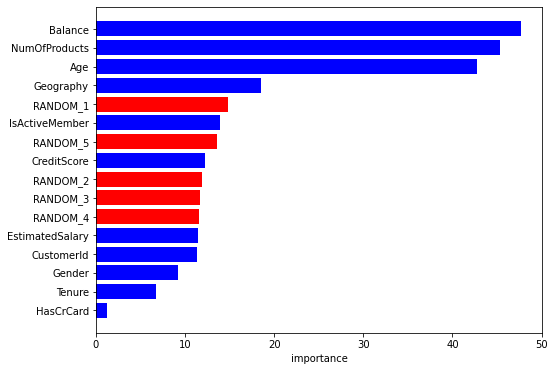

In [10]:
### PLOT IMPORTANCES ###

imp_id = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.barh(range(len(importances)), importances[imp_id], 
         color=['red' if 'RANDOM' in c else 'blue' for c in X_train.columns[imp_id]])
plt.yticks(range(len(importances)), X_train.columns[imp_id])
plt.xlabel('importance')
plt.show()

In [11]:
### TUNE PARAMETERS PLUS RFE AND EXTRACT SUPPORTS ###

supports = np.zeros((df.shape[1]-1,))

for i in range(n_trials):
    
    print("----- TRIAL {} -----".format(i+1))

    X_train, X_valid, y_train, y_valid = train_test_split(
        df.drop(['Exited'], axis=1), df['Exited'], test_size=0.5, shuffle=True, random_state=i)

    model = BoostRFE(lgbm, min_features_to_select=1, step=1, param_grid=param_grid, greater_is_better=True, verbose=0)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=AUC, early_stopping_rounds=5, verbose=0)

    supports += model.support_.astype(int)

----- TRIAL 1 -----
----- TRIAL 2 -----
----- TRIAL 3 -----
----- TRIAL 4 -----
----- TRIAL 5 -----
----- TRIAL 6 -----
----- TRIAL 7 -----
----- TRIAL 8 -----
----- TRIAL 9 -----
----- TRIAL 10 -----


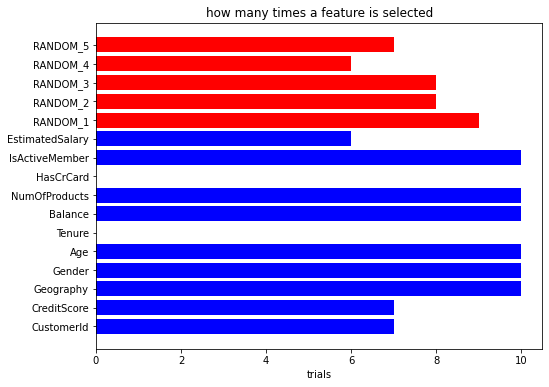

In [12]:

### PLOT VARIABLE SUPPORTS OVER TRIALS ###

plt.figure(figsize=(8,6))
plt.barh(range(len(supports)), supports, 
         color=['red' if 'RANDOM' in c else 'blue' for c in X_train])
plt.yticks(range(len(supports)), X_train.columns); plt.xlabel('trials')
plt.title('how many times a feature is selected')
plt.show()

In [13]:
### TUNE PARAMETERS PLUS BORUTA AND EXTRACT SUPPORTS ###

supports = np.zeros((df.shape[1]-1,))

for i in range(n_trials):
    
    print("----- TRIAL {} -----".format(i+1))

    X_train, X_valid, y_train, y_valid = train_test_split(
        df.drop(['Exited'], axis=1), df['Exited'], test_size=0.5, shuffle=True, random_state=i)

    model = BoostBoruta(lgbm, perc=100, alpha=0.05, max_iter=100, param_grid=param_grid, greater_is_better=True, verbose=0)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=AUC, early_stopping_rounds=5, verbose=0)

    supports += model.support_.astype(int)

----- TRIAL 1 -----
----- TRIAL 2 -----
----- TRIAL 3 -----
----- TRIAL 4 -----
----- TRIAL 5 -----
----- TRIAL 6 -----
----- TRIAL 7 -----
----- TRIAL 8 -----
----- TRIAL 9 -----
----- TRIAL 10 -----


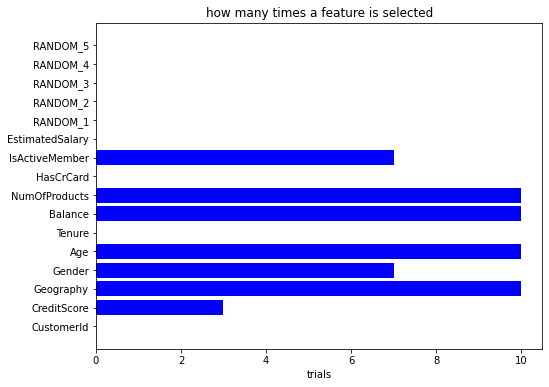

In [14]:

### PLOT VARIABLE SUPPORTS OVER TRIALS ###

plt.figure(figsize=(8,6))
plt.barh(range(len(supports)), supports, 
         color=['red' if 'RANDOM' in c else 'blue' for c in X_train])
plt.yticks(range(len(supports)), X_train.columns); plt.xlabel('trials')
plt.title('how many times a feature is selected')
plt.show()

In [15]:
### TUNE PARAMETERS PLUS RFE WITH SHAP AND EXTRACT SUPPORTS ###

supports = np.zeros((df.shape[1]-1,))

for i in range(n_trials):
    
    print("----- TRIAL {} -----".format(i+1))

    X_train, X_valid, y_train, y_valid = train_test_split(
        df.drop(['Exited'], axis=1), df['Exited'], test_size=0.5, shuffle=True, random_state=i)

    model = BoostRFE(lgbm, min_features_to_select=1, step=1, param_grid=param_grid, greater_is_better=True,
                     importance_type='shap_importances', train_importance=False, verbose=0)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=AUC, early_stopping_rounds=5, verbose=0)

    supports += model.support_.astype(int)

----- TRIAL 1 -----
----- TRIAL 2 -----
----- TRIAL 3 -----
----- TRIAL 4 -----
----- TRIAL 5 -----
----- TRIAL 6 -----
----- TRIAL 7 -----
----- TRIAL 8 -----
----- TRIAL 9 -----
----- TRIAL 10 -----


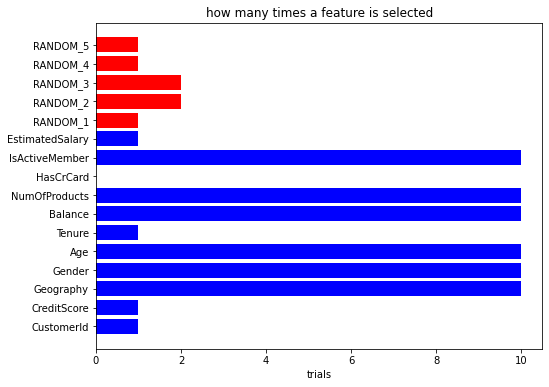

In [16]:
### PLOT VARIABLE SUPPORTS OVER TRIALS ###

plt.figure(figsize=(8,6))
plt.barh(range(len(supports)), supports, 
         color=['red' if 'RANDOM' in c else 'blue' for c in X_train])
plt.yticks(range(len(supports)), X_train.columns); plt.xlabel('trials')
plt.title('how many times a feature is selected')
plt.show()

In [17]:
### TUNE PARAMETERS PLUS BORUTA WITH SHAP AND EXTRACT SUPPORTS ###

supports = np.zeros((df.shape[1]-1,))

for i in range(n_trials):
    
    print("----- TRIAL {} -----".format(i+1))

    X_train, X_valid, y_train, y_valid = train_test_split(
        df.drop(['Exited'], axis=1), df['Exited'], test_size=0.5, shuffle=True, random_state=i)

    model = BoostBoruta(lgbm, perc=100, alpha=0.05, max_iter=100, param_grid=param_grid, greater_is_better=True,
                        importance_type='shap_importances', train_importance=False, verbose=0)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=AUC, early_stopping_rounds=5, verbose=0)

    supports += model.support_.astype(int)

----- TRIAL 1 -----
----- TRIAL 2 -----
----- TRIAL 3 -----
----- TRIAL 4 -----
----- TRIAL 5 -----
----- TRIAL 6 -----
----- TRIAL 7 -----
----- TRIAL 8 -----
----- TRIAL 9 -----
----- TRIAL 10 -----


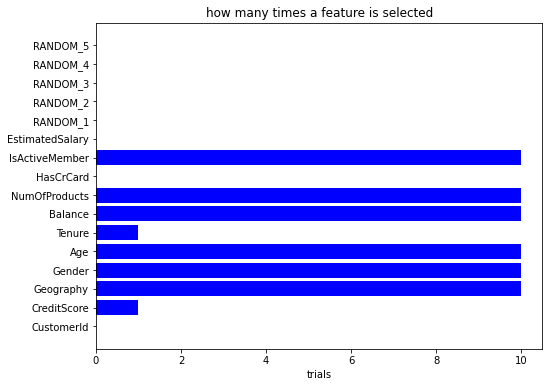

In [18]:

### PLOT VARIABLE SUPPORTS OVER TRIALS ###

plt.figure(figsize=(8,6))
plt.barh(range(len(supports)), supports, 
         color=['red' if 'RANDOM' in c else 'blue' for c in X_train])
plt.yticks(range(len(supports)), X_train.columns); plt.xlabel('trials')
plt.title('how many times a feature is selected')
plt.show()